In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
from helpers import ILottoCSV, beam_search_decoder
from ilotto import ILotto, CosineAnnealingScheduler
print("Tensorflow version " + tf.__version__)
tf.config.optimizer.set_jit(True)

Tensorflow version 2.3.4


In [2]:
import requests
orig_lotto_csv = "input/Orig_IL_lotto.csv"
lotto_csv_file = "input/lotto_IL_filtered.csv"
csv_url = "https://pais.co.il/Lotto/lotto_resultsDownload.aspx"
base_dir = os.path.dirname(orig_lotto_csv)
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
r = requests.get(csv_url)
with open(orig_lotto_csv,'wb') as f:
    f.write(r.content)
ILottoCSV(orig_lotto_csv, lotto_csv_file)

lotto = pd.read_csv(lotto_csv_file, index_col = 'Date')
print(lotto)

            Ball_1  Ball_2  Ball_3  Ball_4  Ball_5  Ball_6  Ball_Bonus
Date                                                                  
06/01/2024       2       5       8       9      10      26           3
02/01/2024       5       9      12      21      22      28           1
30/12/2023       4       8      12      27      33      37           5
26/12/2023       1       3       5      15      29      35           4
23/12/2023       2       7      11      19      22      29           6
...            ...     ...     ...     ...     ...     ...         ...
29/10/1968       3       9      26      32      34      36           1
15/10/1968       1       6      23      29      33      34           7
08/10/1968       7       9      10      17      23      34           4
01/10/1968       1       7       8       9      11      30           4
03/09/1968       3      14      18      22      25      33           2

[2173 rows x 7 columns]


In [3]:
data = lotto.values - 1
train = data[50:]
test = data[:50]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])

X_train, y_train = np.array(X_train), np.array(y_train)
inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [4]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2173, 7)
(2113, 10, 7)
(2113, 7)
(50, 10, 7)
(50, 7)


In [5]:
model = ILotto()  
sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])
model.summary()


Model: "i_lotto"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1110      
_________________________________________________________________
embedding_1 (Embedding)      multiple                  1110      
_________________________________________________________________
embedding_2 (Embedding)      multiple                  1110      
_________________________________________________________________
embedding_3 (Embedding)      multiple                  1110      
_________________________________________________________________
embedding_4 (Embedding)      multiple                  1110      
_________________________________________________________________
embedding_5 (Embedding)      multiple                  1110      
_________________________________________________________________
embedding_6 (Embedding)      multiple                  1110

In [6]:
EPOCHS = 250
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/250
67/67 - 3s - loss: 3.6080 - sparse_top_k: 0.1787 - val_loss: 3.6039 - val_sparse_top_k: 0.1971
Epoch 2/250
67/67 - 1s - loss: 3.5927 - sparse_top_k: 0.2177 - val_loss: 3.5714 - val_sparse_top_k: 0.1943
Epoch 3/250
67/67 - 1s - loss: 3.5351 - sparse_top_k: 0.2177 - val_loss: 3.4860 - val_sparse_top_k: 0.1886
Epoch 4/250
67/67 - 1s - loss: 3.4136 - sparse_top_k: 0.2407 - val_loss: 3.2813 - val_sparse_top_k: 0.3086
Epoch 5/250
67/67 - 1s - loss: 3.2472 - sparse_top_k: 0.3309 - val_loss: 3.1356 - val_sparse_top_k: 0.3914
Epoch 6/250
67/67 - 1s - loss: 3.1392 - sparse_top_k: 0.3804 - val_loss: 3.0499 - val_sparse_top_k: 0.4057
Epoch 7/250
67/67 - 1s - loss: 3.0739 - sparse_top_k: 0.3958 - val_loss: 2.9947 - val_sparse_top_k: 0.4200
Epoch 8/250
67/67 - 1s - loss: 3.0241 - sparse_top_k: 0.4072 - val_loss: 2.9434 - val_sparse_top_k: 0.4571
Epoch 9/250
67/67 - 1s - loss: 2.9914 - sparse_top_k: 0.4127 - val_loss: 2.9128 - val_sparse_top_k: 0.4743
Epoch 10/250
67/67 - 1s - loss: 2.961

0.508571445941925


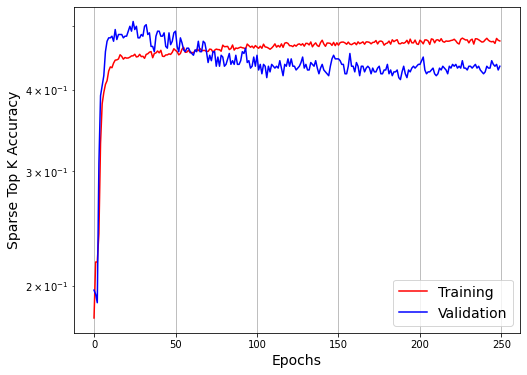

In [7]:
import matplotlib.pyplot as plt
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [8]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

In [9]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 1  9 12 24 28 37  3]
GoundTruth:	 [ 2  5  8  9 10 26  3]
----------------------------------------
Prediction:	 [ 1  8 12 24 28 37  2]
GoundTruth:	 [ 5  9 12 21 22 28  1]
----------------------------------------
Prediction:	 [ 1 10 17 24 28 37  1]
GoundTruth:	 [ 4  8 12 27 33 37  5]
----------------------------------------
Prediction:	 [ 1 10 17 24 28 37  1]
GoundTruth:	 [ 1  3  5 15 29 35  4]
----------------------------------------
Prediction:	 [ 1  9 17 24 28 37  1]
GoundTruth:	 [ 2  7 11 19 22 29  6]
----------------------------------------
Prediction:	 [ 1  9 17 24 30 37  1]
GoundTruth:	 [ 3  5 21 23 34 36  7]
----------------------------------------
Prediction:	 [ 1  9 17 24 28 37  1]
GoundTruth:	 [ 4  7 11 22 28 31  5]
----------------------------------------
Prediction:	 [ 1  9 12 24 28 37  2]
GoundTruth:	 [ 3 11 12 17 19 29  4]
----------------------------------------
Prediction:	 [ 1  9 12 24 30 37  2]
GoundTruth:	 [ 1  8 11 21 27 29  2]
------------------------

In [10]:
X_latest = X_test[0][1:]
X_latest = np.concatenate([X_latest, y_test[0].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[ 1  7 18 23 26 31  4]
  [ 4  8 15 24 29 30  7]
  [11 16 28 29 31 35  3]
  [ 5  7 19 26 32 33  6]
  [ 8 18 25 29 32 35  2]
  [ 5 13 30 33 34 36  3]
  [ 5  6 26 27 30 32  2]
  [17 22 27 33 34 35  2]
  [ 7 12 15 22 28 33  6]
  [ 2  5  8  9 10 26  3]]]


In [11]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

[ 1  8 12 24 28 37  2]


In [12]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 1  8 12 24 28 37  2] 	Log Likelihood:  -16.433651272559555
Prediction:  [ 1  9 12 24 28 37  2] 	Log Likelihood:  -16.43510344670423
Prediction:  [ 1  8 12 24 28 37  3] 	Log Likelihood:  -16.436815078823006
Prediction:  [ 1  9 12 24 28 37  3] 	Log Likelihood:  -16.438267252967684
Prediction:  [ 1  8 11 24 28 37  2] 	Log Likelihood:  -16.440195070983734
Prediction:  [ 1  8 12 24 28 37  1] 	Log Likelihood:  -16.4409640094654
Prediction:  [ 1  9 11 24 28 37  2] 	Log Likelihood:  -16.44164724512841
Prediction:  [ 1  8 12 24 30 37  2] 	Log Likelihood:  -16.442329533555643
Prediction:  [ 1  9 12 24 28 37  1] 	Log Likelihood:  -16.442416183610074
Prediction:  [ 1  8 11 24 28 37  3] 	Log Likelihood:  -16.44335887724719


In [13]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 1  8 12 24 28 37  2] 	Log Likelihood:  -16.433651272559555
Prediction:  [ 1  9 12 24 28 37  2] 	Log Likelihood:  -16.43510344670423
Prediction:  [ 1  8 12 24 28 37  3] 	Log Likelihood:  -16.436815078823006
Prediction:  [ 1  9 12 24 28 37  3] 	Log Likelihood:  -16.438267252967684
Prediction:  [ 1  8 11 24 28 37  2] 	Log Likelihood:  -16.440195070983734
Prediction:  [ 1  9 11 24 28 37  2] 	Log Likelihood:  -16.44164724512841
Prediction:  [ 1  8 12 24 30 37  2] 	Log Likelihood:  -16.442329533555643
Prediction:  [ 1  8 11 24 28 37  3] 	Log Likelihood:  -16.44335887724719
Prediction:  [ 1  9 12 24 30 37  2] 	Log Likelihood:  -16.443781707700317
Prediction:  [ 1  8 12 23 28 37  2] 	Log Likelihood:  -16.444766424142344
